# Velocity gradient from collapse of sonication bubble

We follow the approach taken by https://pubs.acs.org/doi/pdf/10.1021/acs.iecr.1c00233
$$
\rho\left(R\ddot{R} + \frac{3}{2}(\dot{R})^2\right)=\left(p_0 + \frac{2\sigma}{R_0}-p_v\right)\left(\frac{R_0}{R}\right)^{3\kappa} + p_v - \frac{2\sigma}{R} - \frac{4\eta\dot{R}}{R}-p_0-p_A(t)
$$

which can be rearranged as $y=(R, V)$ and:

$$
\begin{aligned}\dot{R}= & V\\
\dot{V}= & -\frac{3}{2}\frac{V^{2}}{R}+\frac{1}{\rho R}\left(\left(p_{0}+\frac{2\sigma}{R_{0}}-p_{v}\right)\left(\frac{R_{0}}{R}\right)^{3\kappa}+p_{v}-\frac{2\sigma}{R}-\frac{4\eta V}{R}-p_{0}-p_{A}(t)\right)
\end{aligned}
$$

In [34]:
import numpy as np
from scipy.integrate import solve_ivp

from ipywidgets import interactive
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

In [35]:
output_file = 'inputs/sonication/scenario_sonication'

# Number of independent scenarios
n_scenarios = 5

# Max distance from the centre normalised by bubble initial radius
alpha_max = 10

## Solve bubble radius

In [36]:
R0 = 10e-6 # m
pv = 3.9e3 # Pa
p0 = 1.01325e5 #Pa
eta = 0.56e-3 #Pa.s
sigma = 0.028 #N/m
rho = 940 # kg/m^3
kappa = 1.4
p1 = p0 + 2*sigma/R0 - pv


pA = 5e5 # Pa
f = 20e3 # Hz

def forcing(t):
    return pA*np.sin(2*np.pi*f*t)

def RayleighPlesset(t, y):
    out = np.empty_like(y)
    out[0] = y[1]
    out[1] = -1.5*y[1]**2/y[0] + 1./(rho*y[0])*(p1*(R0/y[0])**3*(kappa)
                                                + pv - p0 
                                                - 2*sigma/y[0]
                                                - 4*eta*y[1]/y[0]
                                                - forcing(t)
                                               )
    return out

In [37]:
sol = solve_ivp(RayleighPlesset, (0, 100e-6), [R0, 0], max_step=1e-8)

Text(0, 0.5, 'Radius (µm)')

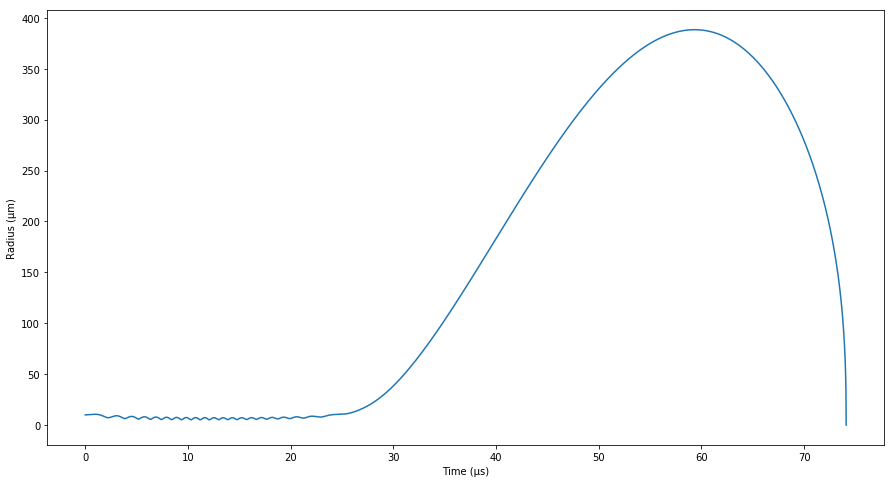

In [38]:
t = sol.t
R = sol.y[0]
V = sol.y[1]

plt.plot(t*1e6, R*1e6)
plt.xlabel('Time (µs)')
plt.ylabel('Radius (µm)')

In [39]:
# Determine validity based on speed of sound
V[np.abs(V) > 450] = np.nan
R[np.abs(R) < 100e-9] = np.nan
M = V*R
V = V[~np.isnan(M)]
R = R[~np.isnan(M)]
t = t[~np.isnan(M)]

## Lagrangian velocity gradients
We define initial positions as:
$$ R_L(0) = \alpha R_0 $$
where $\alpha=1$ if the molecule is sitting at the bubble interface, $\alpha > 1$ otherwise. Using conservation of the volume of the shell between $R(t)$ and $R_L(t)$:
$$ R_L^3(t) = R(t)^3 + (\alpha^3-1) R_0^3 $$
The velocity at the bubble interface is just $\dot{R}(t)$. Again with conservation of volume, we have:
$$ U(r)r^2 = \dot{R}(t)R^2$$
And therefore:
$$ \frac{\partial U}{\partial r} = -2 \frac{\dot{R}(t)R^2}{r^3}$$
Finally, the Lagrangian strain rate is:
$$ \dot{\varepsilon}(\alpha, t) = -2 \frac{\dot{R}(t)R(t)^2}{R(t)^3 + (\alpha^3-1) R_0^3}$$

In [40]:
# Lagrangian radius, RL0 = alpha*R0, so alpha > 1
alphas = np.logspace(0,np.log10(alpha_max),n_scenarios)
RL3s = []
for alpha in alphas:
    RL3s.append(R**3 + (alpha**3 -1)*R0**3)
# Strain rates
Es = []
for RL3 in RL3s:
    Es.append(-2*V*R**2/RL3)
Hs = []
dt = np.zeros_like(t)
dt[1:] = np.diff(t)
for E in Es:
    Hs.append(np.cumsum(E*dt))

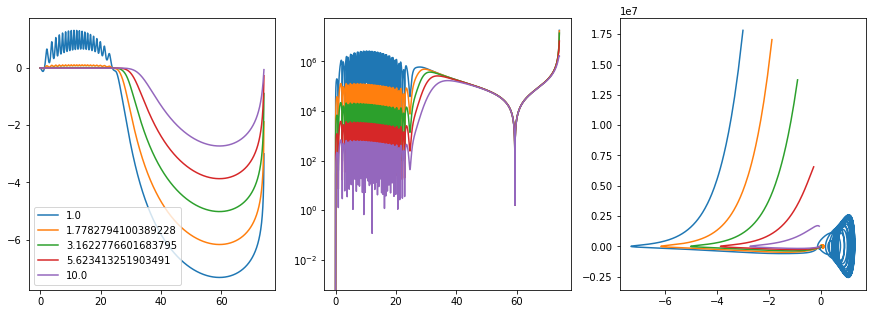

In [41]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(nrows=1, ncols=3)
for alpha, H in zip(alphas, Hs):
    ax[0].plot(t*1e6, H, label=alpha)
ax[0].legend()
for E in Es:
    ax[1].semilogy(t*1e6, np.abs(E))
for E, H in zip(Es, Hs):
    ax[2].plot(H, E)
#ax[1].plot(H, Es)

In [42]:
max_E = max(list(np.amax(E[10:]) for E in Es))
t = t*max_E
for i, E in enumerate(Es):
    Es[i] = E/max_E

## Crop

## Normalise

In [43]:
def zoom(tb):
    figure, ax = plt.subplots(nrows=2)
    for E in Es:
        ax[0].plot(t, E, linewidth=2)
    ax[0].axvline(t[tb[0]])
    ax[0].axvline(t[tb[1]])
    
    for E in Es:
        ax[1].semilogy(t[tb[0]:tb[1]], np.abs(E[tb[0]:tb[1]]), linewidth=2)
    ax[1].set_title('Crop')
    ax[1].axhline(1e-3)
    
    
    
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(t)-1],
                    description='Index range:',
                    min=0,
                    max=len(t)-1, 
                    continuous_update=False
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 7409), continuous_update=False, description='Index range:', max…

In [44]:
tmin, tmax = w.kwargs['tb']
t = t[tmin:tmax] - t[tmin]
t = np.hstack((t, [t[-1]+0.01, t[-1]+10]))

gradUs = []
for E in Es:
    gradU = np.zeros((len(t), 3, 3))
    gradU[:-2, 0, 0] = E[tmin:tmax]
    gradU[:-2, 1, 1] = -0.5*E[tmin:tmax]
    gradU[:-2, 2, 2] = -0.5*E[tmin:tmax]
    gradUs.append(gradU)

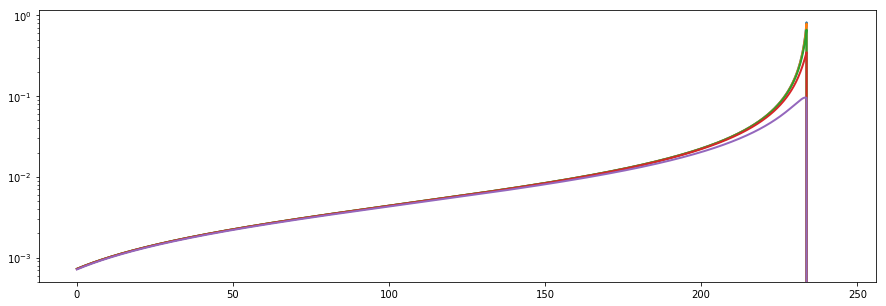

In [45]:
for gradU in gradUs:
    plt.semilogy(t, gradU[:, 0, 0], linewidth=2)

In [46]:
for i, gradU in enumerate(gradUs):
    np.savez_compressed(f"{output_file}_{i}", t=t, gradU=gradU)